In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines){
    return false;
}

<IPython.core.display.Javascript object>

In [40]:
import pandas as pd
import statsmodels
import matplotlib.pyplot as plt
import math
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
from scipy.fftpack import fft
import random
from random import randrange
import statsmodels.api as sm
import progressbar
random.seed(1)

In [3]:
cd ..

/Users/yeehonglow/Documents/Imperial/Machine-Learning-to-Track-Cloud-Computing


In [5]:
x_axis = np.arange(0, 29-1/288, 1/288).tolist()
np_cpu = np.load("dataset//google-cpu-full.npy")

# full_cpu is a list of pandas series of the cpu utilisation of all machines
# just a lazy way of converting nd-arrays to pd-series
full_cpu = []
for x in range (0,len(np_cpu)):
    full_cpu.append(pd.Series(np_cpu[x], index = x_axis))  
    
random_samples = [34, 150, 352, 365, 416, 464, 475, 501, 565, 1033, 1416, 1537, 1638, 1674, 1768, 1931, 1980, 2201, 
                  2682, 2834, 3045, 3110, 3439, 3548, 3584, 3632, 3748, 3782, 3818, 3977, 4179, 4363, 4655, 4747, 
                  4856, 4970, 5200, 5450, 5663, 6014, 6070, 6139, 6219, 6245, 6386, 6443, 6444, 6623, 6788, 6818, 
                  6915, 7090, 7174, 7191, 7297, 7364, 7530, 7737, 7868, 7993, 8023, 8117, 8123, 8181, 8205, 8278, 
                  8318, 8330, 8535, 8644, 8870, 8991, 9058, 9116, 9325, 9626, 9650, 9685, 9952, 10311, 10523, 10642,
                  10675, 10875, 10891, 10982, 11050, 11089, 11247, 11400, 11518, 11652, 11820, 11821, 11856, 11892,
                  12094, 12175, 12185, 12467]    
five_examples = [100, 365, 9626, 10875, 11821]

In [60]:
def decompose(timeseries, timeseries_index, bar_f = "Day", sub_plot = False):
    '''
    decompose the time-series into three different components: trend, seasonal, residual
    
    trend: overall change across time of time-series
    seasonal: periodic component of the time-series 
    residual: the random component of the time-series, resembling noise
    
    params:
    timeseries -- the time-series to be decomposed
    timeseries_index -- index of the time-series, for plotting purposes
    bar_f -- the period in which the seasonal component is identified, analogous to rolling mean window
    sub_plot -- set to true to plot different components in different subplots, set to false to plot everything in a single graph
    
    return decomposed time-series object
    '''
    
    naming = bar_f
    
    if(bar_f == "Day"):
        bar_f = 288
    elif(bar_f == "Week"):
        bar_f = 288*7
    
    import statsmodels.api as sm
    timeseries_stl = sm.tsa.seasonal_decompose(timeseries, freq = bar_f)
    
    if(sub_plot):
        fog, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize = (20,20))
        timeseries.plot(ax = ax1)
        timeseries_stl.trend.plot(ax = ax2)
        timeseries_stl.seasonal.plot(ax = ax3)
        timeseries_stl.resid.plot(ax = ax4)
        ax1.grid()
        ax2.grid()
        ax3.grid()
        ax4.grid()
        ax1.set_title("Timeseries", font_size = 18)
        ax2.set_title("Trend", font_size = 18)
        ax3.set_title("Seasonality", font_size = 18)
        ax4.set_title("Residuals", font_size = 18)
        plt.tight_layout()
        
    else:
        plt.figure(figsize=(16,4))
        plt.plot(x_axis,timeseries_stl.trend, color = 'blue', label = "Trend") 
        plt.plot(x_axis,timeseries_stl.resid, color = 'green', label = "Residual") 
        plt.plot(x_axis,timeseries_stl.seasonal, color = 'red', label = "Seasonal") 
        plt.title("Machine " + str(timeseries_index) + ", " + naming, fontsize = 18)  
        plt.xlabel("Days", fontsize = 16)  
        plt.ylabel("Mean CPU Utilisation", fontsize = 16)  
        plt.legend()
        plt.grid()
        plt.savefig("figures//analysis//decomposition//" + naming + "_decomposition_" + str(timeseries_index))
        plt.show()
        
    return timeseries_stl    

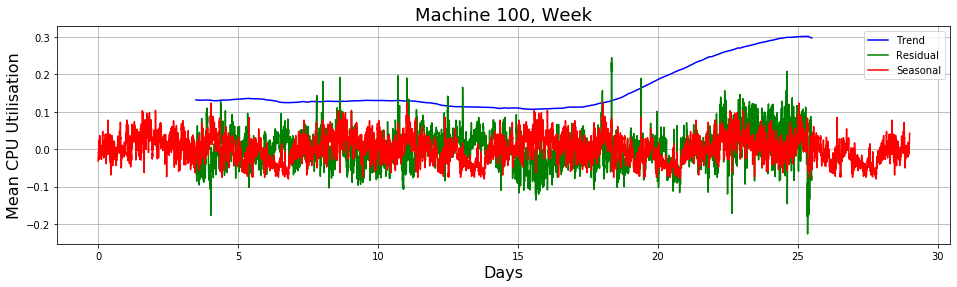

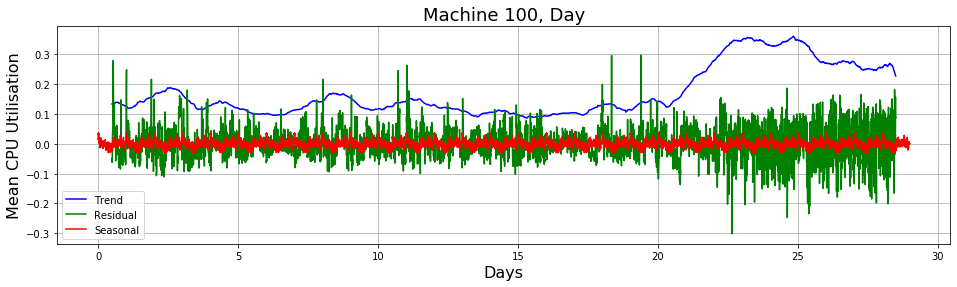

In [61]:
current_index = 0
decompose(full_cpu[five_examples[current_index]], 
          timeseries_index = five_examples[current_index], 
          bar_f = "Week")
decompose(full_cpu[five_examples[current_index]], 
          timeseries_index = five_examples[current_index], 
          bar_f = "Day")

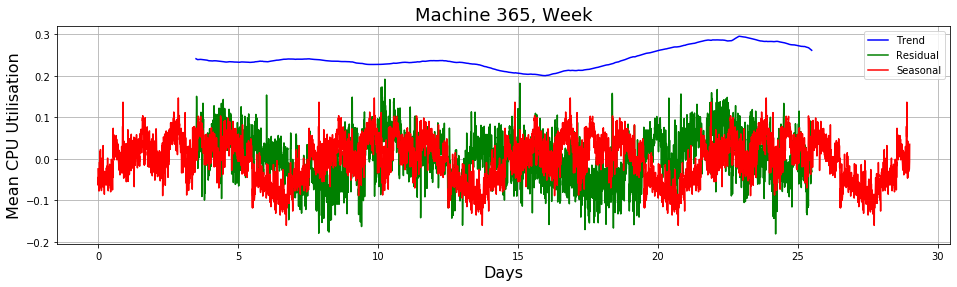

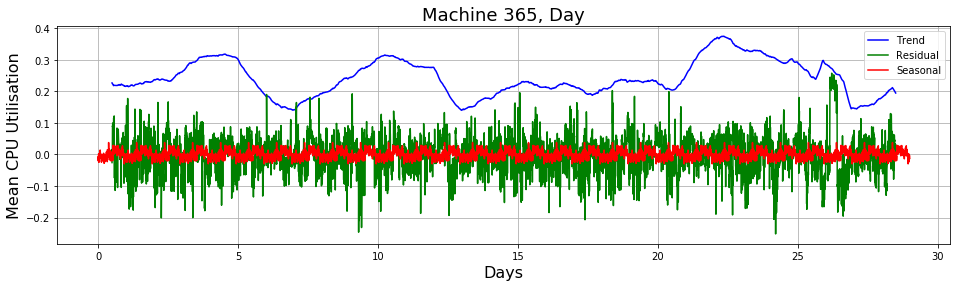

In [62]:
current_index = 1
decompose(full_cpu[five_examples[current_index]], 
          timeseries_index = five_examples[current_index], 
          bar_f = "Week")
decompose(full_cpu[five_examples[current_index]], 
          timeseries_index = five_examples[current_index], 
          bar_f = "Day")

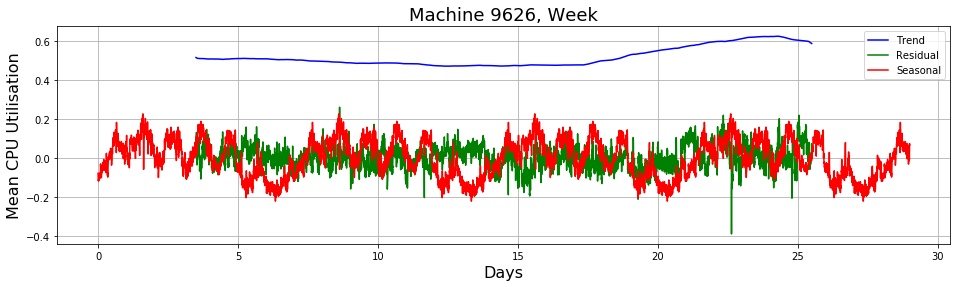

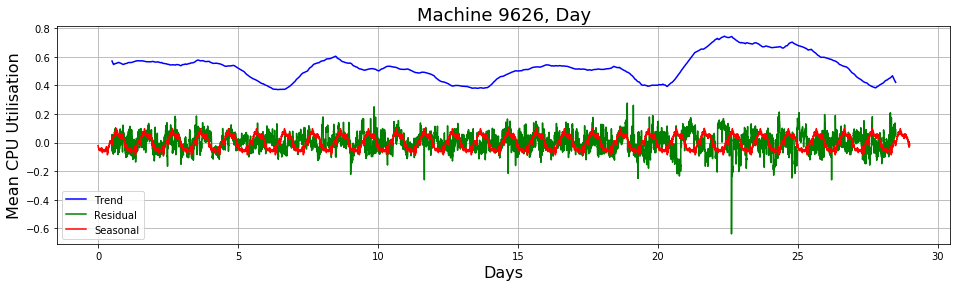

In [63]:
current_index = 2
decompose(full_cpu[five_examples[current_index]], 
          timeseries_index = five_examples[current_index], 
          bar_f = "Week")
decompose(full_cpu[five_examples[current_index]], 
          timeseries_index = five_examples[current_index], 
          bar_f = "Day")

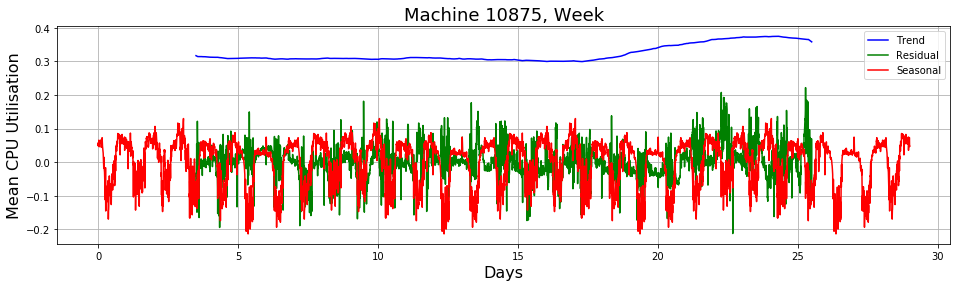

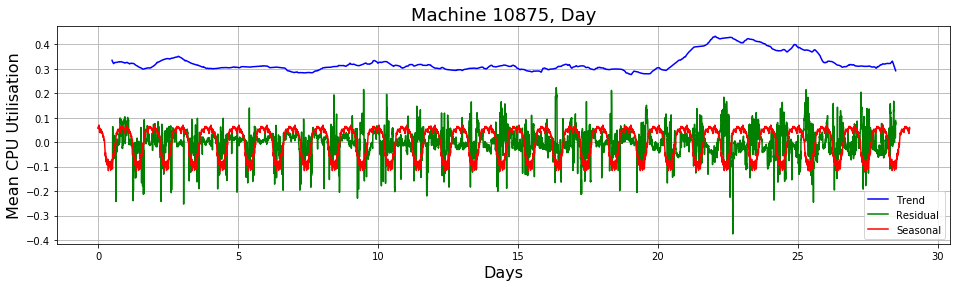

In [64]:
current_index = 3
decompose(full_cpu[five_examples[current_index]], 
          timeseries_index = five_examples[current_index], 
          bar_f = "Week")
decompose(full_cpu[five_examples[current_index]], 
          timeseries_index = five_examples[current_index], 
          bar_f = "Day")

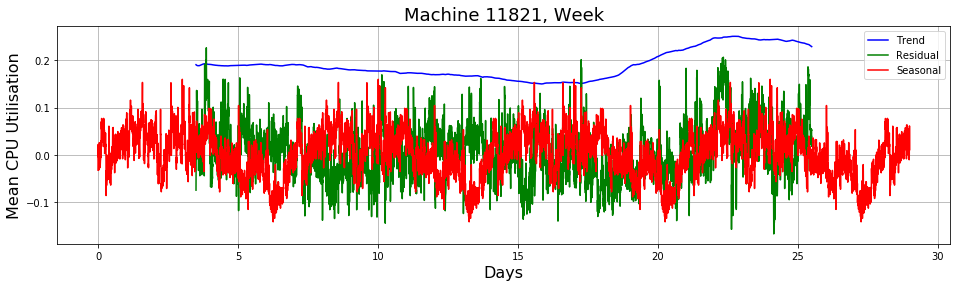

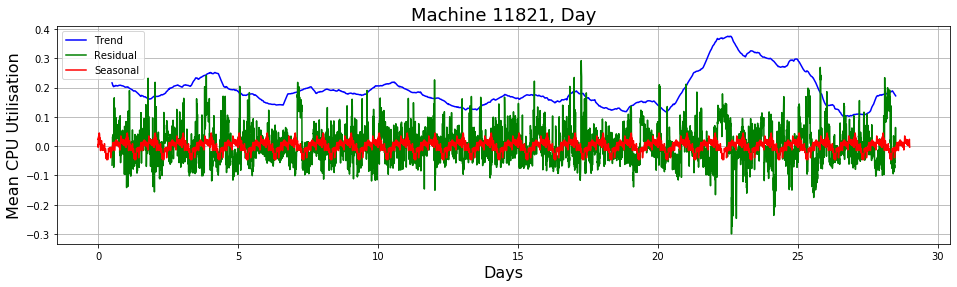

In [65]:
current_index = 4
decompose(full_cpu[five_examples[current_index]], 
          timeseries_index = five_examples[current_index], 
          bar_f = "Week")
decompose(full_cpu[five_examples[current_index]], 
          timeseries_index = five_examples[current_index], 
          bar_f = "Day")

In [56]:
def compare_components(cpu_data, selected_machines, bar_f = "day"):
    '''
    comparing the statistics of different components
    
    params: 
    cpu_data -- cpu utilisation of all machines
    selected_machines -- ls of index of machines to consider
    bar_f -- the period in which the seasonal component is identified, analogous to rolling mean window
    
    returns df which contains the mean and std of each components
    '''

    if bar_f == "day":
        bar_f = 288
    elif bar_f == "week":
        bar_f = 288*7
    
    with progressbar.ProgressBar(max_value = len(selected_machines)) as bar:
        for counter, x in enumerate(selected_machines):
            
            bar.update(counter)
            
            decompose_results = sm.tsa.seasonal_decompose(cpu_data[x], freq = bar_f)
            mean_list = [decompose_results.trend.mean(),
                        decompose_results.seasonal.mean(),
                        decompose_results.resid.mean()]
            std_list = [decompose_results.trend.std(),
                        decompose_results.seasonal.std(),
                        decompose_results.resid.std()]
        
    indexing = ["Trend",
                "Seasonal", 
                "Residual"]    
    
    statistics_mapping = {
        "Mean": mean_list,
        "Standard Deviation": std_list
    }    
    statistics_df = pd.DataFrame(statistics_mapping, index = indexing)

    return statistics_df

In [58]:
compare_components(full_cpu, np.arange(0,len(full_cpu)), bar_f = "day")

100% (12476 of 12476) |##################| Elapsed Time: 0:04:52 Time:  0:04:52


,Mean,Standard Deviation
Trend,0.188349,0.042838
Seasonal,0.000001,0.020159
Residual,0.000189,0.056555


In [59]:
compare_components(full_cpu, np.arange(0,len(full_cpu)), bar_f = "week")

100% (12476 of 12476) |##################| Elapsed Time: 0:32:58 Time:  0:32:58


,Mean,Standard Deviation
Trend,0.188242,0.026896
Seasonal,0.000351,0.040223
Residual,0.001947,0.054064
